# 2D Space - Entorhinal Modularisation - 21st August 2024

The goal of this notebook is to train an agent to decode both its own position, and the displacement to a reward. The reward will change across environments. We will try and show that in range independent cases, it modularises, else it doens't.

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
from mpl_toolkits.mplot3d import Axes3D
import math
import optax
import scipy
import jax

## Generating labels

Three cases:
1) Totally random reward position
2) Half random, half in one position
3) Totally in one position
4) Some other proportion random

In [65]:
sampling_choice = 4 # Correspond to 1, 2, and 3 above.
num_samples = 10 # Number of rooms to sample
L = 3 # Size of room

prob = 0.25 # The prob for fixed in sampling_choice 4

def generate_data(L, num_samples):
    labels = np.zeros([L**2*2, L, L, num_samples]) # This is the output matrix, x and y current position, and displacement to reward, in each position, for each room
    object_positions = np.zeros([2, num_samples]) # Where is the object in each room
    all_positions = np.array([[i,j] for i in range(L) for j in range(L)])
    if sampling_choice == 3:
        for d in range(num_samples):
            if np.random.sample(1) < 0.5:
                object_positions[:,d] = np.array([[0,0]])
            else:
                object_positions[:,d] = np.array([[1, 1]])
    elif sampling_choice == 2:
        for d in range(num_samples):
            if np.random.sample(1) < prob:
                object_positions[:,d] = np.random.choice(L, [2]) # x and y position of each of the three objects
            else:
                object_positions[:,d] = np.array([[1, 1]])
    elif sampling_choice == 1:
        object_positions = np.random.choice(L, [2, num_samples])
        
    elif sampling_choice == 4:
        for d in range(num_samples):
            if np.random.sample(1) < 0.5:
                object_positions[:,d] = np.random.choice(L, [2]) # x and y position of each of the three objects
            else:
                object_positions[:,d] = np.array([[1, 1]])
    
    for room in range(num_samples):
        object_position = object_positions[:,room]
        for l_x in range(L):
            for l_y in range(L):
                # First ensure one set of labels encodes position
                one_hot_ind = np.where(np.logical_and(all_positions[:,0] == l_x, all_positions[:,1] == l_y))[0]
                labels[one_hot_ind, l_x, l_y, room] = 1
    
                # Now go through and calculate shortest action to object
                distance = object_position - np.array([l_x, l_y])
                distance[distance > L] = distance[distance > L] - L
                distance[distance < 0] = distance[distance < 0] + L
                one_hot_ind = np.where(np.logical_and(all_positions[:,0] == distance[0], all_positions[:,1] == distance[1]))[0]
                labels[L**2+one_hot_ind, l_x, l_y, room] = 1


    # Finally we create the network's one-hot inputs for these rooms.
    inputs = np.zeros([L**2, num_samples])
    for d in range(num_samples):
        pos = object_positions[:,d]
        one_hot_code_ind = np.where(np.logical_and(all_positions[:,0] == pos[0,None], all_positions[:,1] == pos[1,None]))[0]
        inputs[one_hot_code_ind, d] = 1
    
    return labels, object_positions, inputs


labels, object_positions, inputs = generate_data(L, num_samples)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

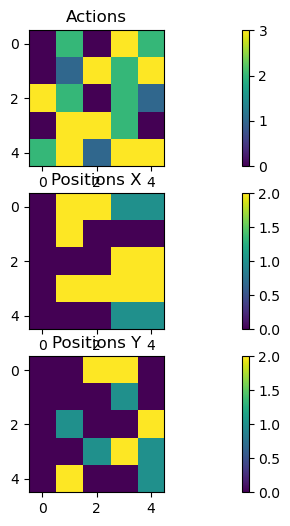

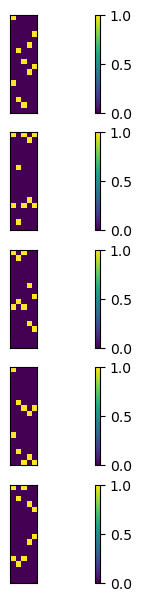

In [66]:
# Create random data to feed the network
T = 5 #L**2 # Length of each trajectory
D = 5 # How many rooms to sample

# Set up step matrix
steps = np.zeros([4, 2])
steps[0,0] = -1
steps[1,0] = 1
steps[2,1] = -1
steps[3,1] = 1

all_object_positions = np.meshgrid(np.arange(L), np.arange(L))
all_object_positions = np.stack([np.ndarray.flatten(all_object_positions[0]), np.ndarray.flatten(all_object_positions[1])]) - 0.5

def generate_trajectories_random(T, D, L):
    # Set up actions, have to explore the room for the first L**2 - 1 timesteps, then random
    actions = np.random.choice(4, [T,D])
    actions = actions.astype(int)
    
    # Given actions, compute the positions
    positions = np.zeros([2, T, D])
    for t in range(1, T):
        positions[:,t,:] = np.mod(positions[:,t-1,:] + steps[actions[t-1,:]].T, L) # This is for periodic
    positions = positions.astype(int)

    labels, object_positions, inputs = generate_data(L, D)
    
    network_signals = np.zeros([2*L**2,T,D])
    for d in range(D):
        for t in range(T):
            for input_dim in range(2*L**2):
                network_signals[input_dim,t,d] = labels[input_dim, positions[0,t,d], positions[1,t,d],d]
            
    return actions, positions, network_signals, inputs, object_positions

actions, positions, network_signals, inputs, object_positions = generate_trajectories_random(T, D, L)

plt.figure(figsize = (20, 6))
plt.subplot(3,1,1)
plt.imshow(actions.T)
plt.title('Actions')
plt.xticks()
plt.yticks()
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(positions[0,:,:].T)
plt.title('Positions X')
plt.xticks()
plt.yticks()
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(positions[1,:,:].T)
plt.title('Positions Y')
plt.xticks()
plt.yticks()
plt.colorbar()

plt.figure(figsize = (15,15))
plot_rows = 10
plot_cols = int(D/plot_rows)+1
for room in range(D):
    plt.subplot(plot_rows, plot_cols, room+1)
    plt.imshow(network_signals[:,:,room])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

inputs

In [67]:
# Define initialising functions, and losses
num_actions = 4
 
# Initialise Ws orthogonal, and others random
def initialise_weights(N, random_seed, init_scale = 0.01):
    W = jnp.zeros([num_actions, N, N+1])
    key = random.PRNGKey(random_seed)

    for n in range(num_actions):
        key, subkey = random.split(key)
        W = W.at[n,:,-1].set(random.normal(subkey, (N,))*init_scale)

        Wp = random.normal(key, (N,N))
        Wp, S, V = jnp.linalg.svd(Wp)
        W = W.at[n,:,:N].set(Wp)

    R = random.normal(key, (2*L**2, N+1))*init_scale
    I = random.normal(key, (N, L**2+1))*init_scale
    params = {'W':W, 'R':R, 'I':I}
    
    return params

@jit
def generate_rep(params, inputs, actions):
    # Inputs dim x traj length x rooms, actions traj length x rooms
    g = jnp.zeros([N, T, D])
    g = g.at[:,0,:].set(params['I'][:,:-1]@inputs[:,:] + params['I'][:,-1][:,None])

    # For rest we just recurrently go around.
    for t in range(1,T):
        g = g.at[:,t,:].set(jnp.einsum('ijk,ki->ji', params['W'][actions[t-1],:,:-1],g[:,t-1,:]) + params['W'][actions[t-1],:,-1].T)
    return g

@jit
def loss_weight(W):
    return jnp.sum(jnp.power(W[:,:-1], 2))

@jit
def loss_act(g):
    return jnp.mean(jnp.sum(jnp.power(g, 2), 0))

@jit
def loss_pos(g):
    return jnp.mean(jnp.sum(jnn.relu(-g), 0))

@jit
def loss_fit(g, R, outputs):
    preds = jnp.einsum('ij, jkl -> ikl', R[:,:-1], g) + R[:,-1][:,None,None]
    return jnp.mean(jnp.sum(jnp.power(outputs - preds, 2), 0))

@jit
def generate_pred(params, g):
    preds = jnp.einsum('ij, jkl -> ikl', params['R'][:,:-1], g) + params['R'][:,-1][:,None,None]
    return preds

In [68]:
mu_fit = 100
mu_G = 0.1
mu_W = 0.01
mu_pos = 100
fit_thresh = 0.001

@jit
def loss(params, inputs, network_signals, actions):
    g = generate_rep(params, inputs, actions)
    
    fitting_loss = loss_fit(g, params['R'], network_signals)  
    
    weight_loss = 0
    for i in range(4):
        weight_loss += loss_weight(params['W'][i,:,:])
    weight_loss += loss_weight(params['R'])
    weight_loss += loss_weight(params['I'])
    
    return mu_fit*jnn.relu(fitting_loss-fit_thresh) + mu_G*loss_act(g) + mu_W*weight_loss + mu_pos*loss_pos(g)

@jit
def update(params, inputs, network_signals, actions, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, inputs, network_signals, actions)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

N = 64
random_seed = 5325731431
learning_rate = 1e-3 #2e-5
scale = 0.1
key = random.PRNGKey(random_seed)

re_init = 1
if re_init:
    optimizer = optax.adam(learning_rate)
    params = initialise_weights(N, random_seed, init_scale = scale)
    opt_state = optimizer.init(params)
    min_loss = np.infty
else:
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
print(loss(params, inputs, network_signals, actions))

726.4474


In [69]:
g = generate_rep(params, inputs, actions)

def calc_acc(g, params, network_signals):
    preds = generate_pred(params, g)
    pred_round = np.rint(preds)
    return jnp.sum(pred_round == network_signals)/jnp.size(pred_round)

min_loss = np.infty
calc_acc(g, params, network_signals)

Array(0.88, dtype=float32)

In [70]:
num_timesteps = 100000000 # Number of steps max
resample_trajs = 1 # How often to resample

# Some mechanics
print_iter = 5000
min_this_step = 1
D = 10
T = 25

for step in range(num_timesteps):
    if step % resample_trajs == 0:
        actions, positions, network_signals, inputs, object_positions = generate_trajectories_random(T, D, L)

    params, opt_state, loss_val = update(params,  inputs, network_signals, actions, opt_state)

    if step % print_iter == 0:
        g = generate_rep(params, inputs, actions)
        
        fitting_loss = loss_fit(g, params['R'], network_signals)
        
        weight_loss_W = 0
        for i in range(4):
            weight_loss_W += loss_weight(params['W'][i,:,:])
        weight_loss_R = loss_weight(params['R'])
        weight_loss_I = loss_weight(params['I'])
        
        L_a = loss_act(g)
        L_p = loss_pos(g)
        acc = calc_acc(g, params, network_signals)

        loss_comp = mu_fit*jnn.relu(fitting_loss-fit_thresh) + mu_G*L_a + mu_W*(weight_loss_W + weight_loss_R + weight_loss_I) + mu_pos*L_p
        print(f"Step {step}, Loss: {loss_val:.5f}, Acc: {acc:.5f}, Fit: {fitting_loss:.5f}, Act: {L_a:.5f}, Wei: {weight_loss_W:.5f}, R: {weight_loss_R:.5f}, I: {weight_loss_I:.5f}, Pos: {L_p:.5f}")

        min_this_step = 0


    if loss_val < min_loss:
        params_best = params
        min_loss = loss_val
        if min_this_step == 0:
            print(f'New min! {loss_val}')
            min_this_step = 1
            

Step 0, Loss: 1159.72656, Acc: 0.83156, Fit: 3.09044, Act: 5.90748, Wei: 254.30020, R: 11.11076, I: 5.90179, Pos: 7.41693
New min! 1159.7265625
Step 5000, Loss: 14.37290, Acc: 1.00000, Fit: 0.12104, Act: 4.47012, Wei: 142.70618, R: 30.62597, I: 7.95708, Pos: 0.00167
New min! 2.8441600799560547
Step 10000, Loss: 2.45251, Acc: 1.00000, Fit: 0.00532, Act: 3.57940, Wei: 126.70268, R: 31.34528, I: 5.80930, Pos: 0.00009
New min! 2.1079370975494385
Step 15000, Loss: 1.96671, Acc: 1.00000, Fit: 0.00211, Act: 3.16555, Wei: 112.32632, R: 29.94632, I: 5.42839, Pos: 0.00001
New min! 1.8186397552490234
Step 20000, Loss: 1.75890, Acc: 1.00000, Fit: 0.00175, Act: 2.84277, Wei: 100.83046, R: 28.47812, I: 5.24249, Pos: 0.00000
New min! 1.6472405195236206
Step 25000, Loss: 3.00434, Acc: 1.00000, Fit: 0.01360, Act: 3.01371, Wei: 91.54578, R: 27.36110, I: 5.28249, Pos: 0.00024
New min! 1.5295230150222778
Step 30000, Loss: 1.50836, Acc: 1.00000, Fit: 0.00198, Act: 2.69986, Wei: 84.49696, R: 26.26662, I: 5.

KeyboardInterrupt: 

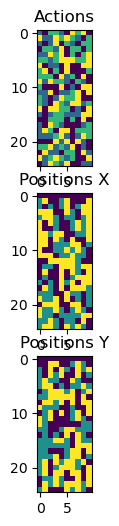

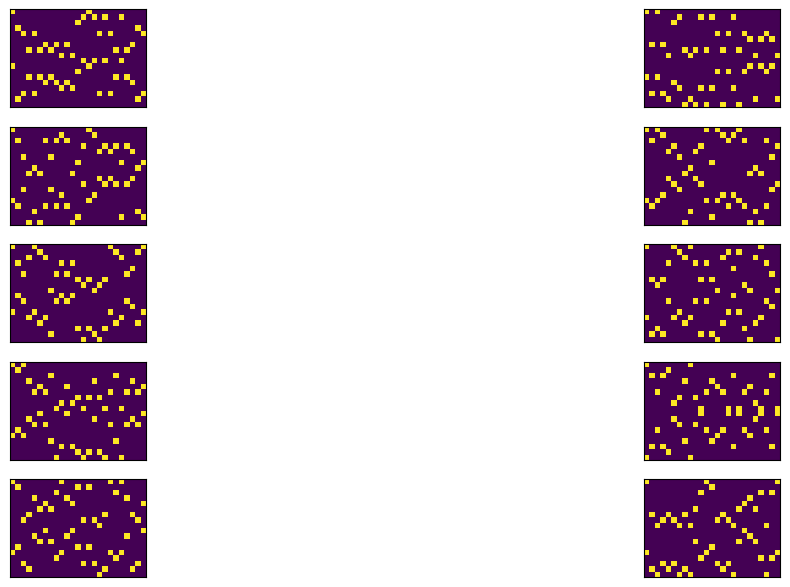

In [71]:
actions, positions, network_signals,inputs, object_positions = generate_trajectories_random(T, D, L)
plt.figure(figsize = (20, 6))
plt.subplot(3,1,1)
plt.imshow(actions)
plt.title('Actions')
plt.xticks()
plt.yticks()

plt.subplot(3,1,2)
plt.imshow(positions[0,:,:])
plt.title('Positions X')
plt.xticks()
plt.yticks()

plt.subplot(3,1,3)
plt.imshow(positions[1,:,:])
plt.title('Positions Y')
plt.xticks()
plt.yticks()

plt.figure(figsize = (15,15))
plot_rows = 10
plot_cols = int(D/plot_rows)+1
for room in range(D):
    plt.subplot(plot_rows, plot_cols, room+1)
    plt.imshow(network_signals[:,:,room])
    plt.xticks([])
    plt.yticks([])
    #plt.clim([0,2])

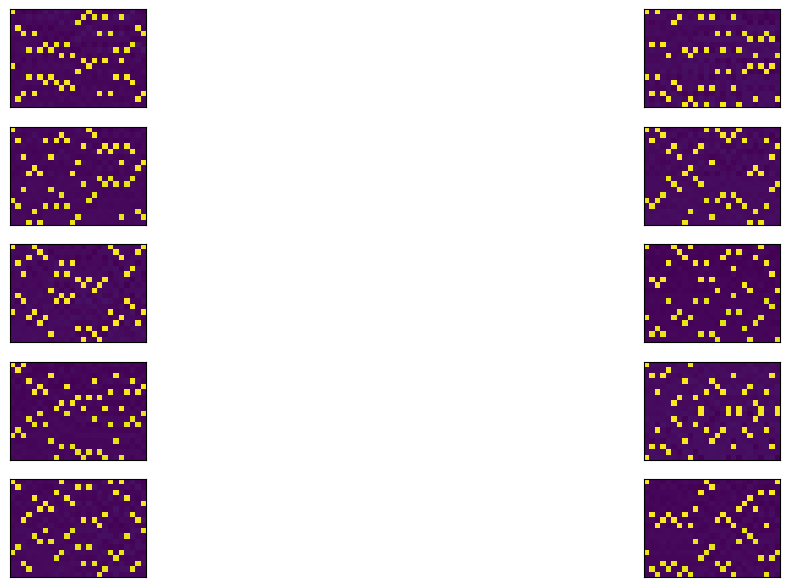

In [72]:
g = generate_rep(params_best, inputs, actions)
preds = generate_pred(params, g)

plt.figure(figsize = (15,15))
plot_rows = 10
plot_cols = int(D/plot_rows)+1
for room in range(D):
    plt.subplot(plot_rows, plot_cols, room+1)
    plt.imshow(preds[:,:,room])
    plt.xticks([])
    plt.yticks([])
    #plt.clim([0,2])

In [73]:
np.save(f'./data/PI_Learnt_Reps/prop_{prob}_1.npy',params_best)